## Solving an Optimization Problem in an Active RIS-Assisted ISAC System Using DRL Algorithms (DDPG and SAC).

This project focuses on solving an optimization problem in an active Reconfigurable Intelligent Surface (RIS)-assisted Integrated Sensing and Communication (ISAC) system using Deep Reinforcement Learning (DRL) algorithms. The goal is to maximize the dual-function radar sensing base station (DFRC BS) by jointly optimizing the beamforming matrix 𝑊 W of the base station and the reflection phase shift matrix of the active RIS, all while ensuring the Signal-to-Interference-plus-Noise Ratio (SINR) of the communication user is maintained. The project employs DRL algorithms, specifically Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC), to achieve the optimization. It involves creating a custom environment in OpenAI Gym, integrating it with Stable Baselines3 for training the DRL models, and comparing the performance and convergence of ordinary DDPG, double DDPG, and SAC algorithms through simulation and graphical analysis. The outcome of this project aims to enhance the efficiency and performance of ISAC systems in modern wireless communication networks.

In [1]:
!pip install gymnasium #Install if necessary and missing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.9 MB/s eta 0:00:00


In [2]:
!pip install stable_baselines3

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Streaming output truncated to the last 5000 lines.
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | -0.48    |
| time/              |          |
|    episodes        | 212      |
|    fps             | 38       |
|    time_elapsed    | 111      |
|    total_timesteps | 4261     |
| train/             |          |
|    actor_loss      | 0.102    |
|    critic_loss     | 0.00054  |
|    learning_rate   | 0.001    |
|    n_updates       | 4160     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | -0.474   |
| time/              |          |
|    episodes        | 216      |
|    fps             | 38       |
|    time_elapsed    | 114      |
|    total_timesteps | 4373     |
| train/             |          |
|    actor_loss      | 0.0951   |
|    critic_loss     | 0.000614 |
|    learning_rate   | 0.001    |
|    n_updates       | 4272     |
-------------------------------

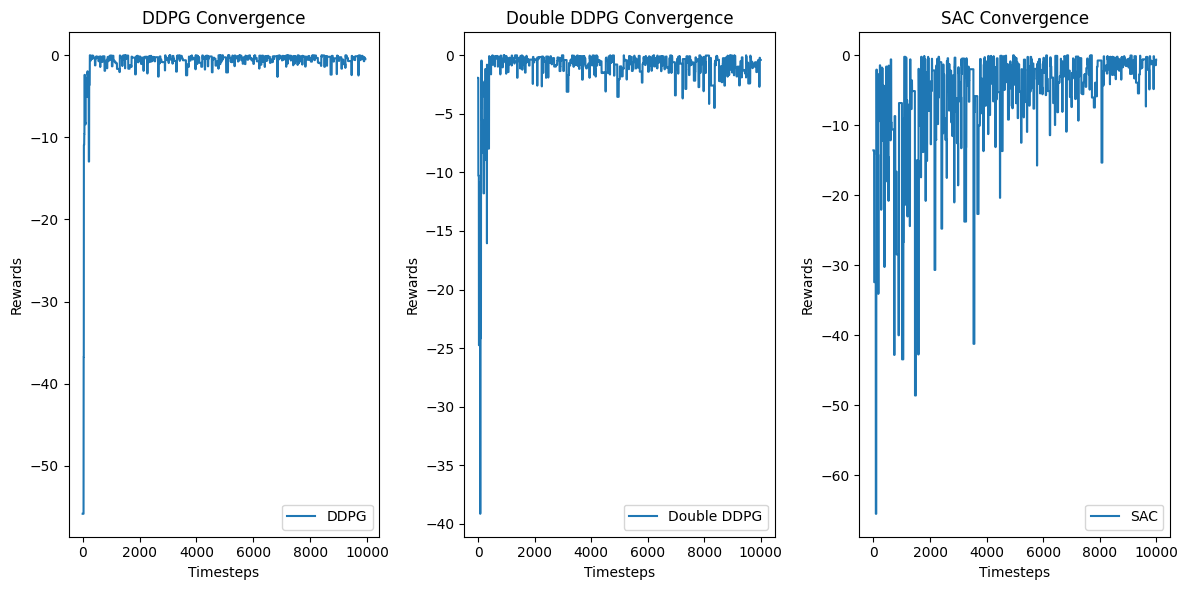

In [3]:
#import all the neccessary libraries
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import DDPG, SAC, TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# Define the custom environment for the ISAC system optimization problem
class ISACEnv(gym.Env):
    def __init__(self):
        super(ISACEnv, self).__init__()
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.random.rand(4)
        info = {}
        return self.state, info

    def step(self, action):
        reward = -np.sum((action - 0.5)**2)
        self.state = np.random.rand(4)
        terminated = np.random.rand() > 0.95
        truncated = False
        info = {}
        return self.state, reward, terminated, truncated, info

    def render(self, mode='human', close=False):
        pass

# Custom callback to record training progress
class TrainLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainLogger, self).__init__(verbose)
        self.rewards = []

    def _on_step(self) -> bool:
        if self.model.ep_info_buffer:
            last_episode_info = self.model.ep_info_buffer[-1]
            if 'r' in last_episode_info:
                self.rewards.append(last_episode_info['r'])
        return True

# Create and wrap the environment
env = DummyVecEnv([lambda: Monitor(ISACEnv())])

# Create action noise for DDPG and TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Train DDPG model
ddpg_logger = TrainLogger()
ddpg_model = DDPG('MlpPolicy', env, action_noise=action_noise, verbose=1, device='cpu')
ddpg_model.learn(total_timesteps=10000, callback=ddpg_logger)

# Train Double DDPG (using TD3 as Double DDPG)
double_ddpg_logger = TrainLogger()
double_ddpg_model = TD3('MlpPolicy', env, action_noise=action_noise, verbose=1, device='cpu')
double_ddpg_model.learn(total_timesteps=10000, callback=double_ddpg_logger)

# Train SAC model
sac_logger = TrainLogger()
sac_model = SAC('MlpPolicy', env, verbose=1, device='cpu')
sac_model.learn(total_timesteps=10000, callback=sac_logger)

# Plot the convergence results
plt.figure(figsize=(12, 6))

# Plot DDPG training rewards
plt.subplot(1, 3, 1)
plt.plot(ddpg_logger.rewards, label='DDPG')
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('DDPG Convergence')
plt.legend()

# Plot Double DDPG training rewards
plt.subplot(1, 3, 2)
plt.plot(double_ddpg_logger.rewards, label='Double DDPG')
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('Double DDPG Convergence')
plt.legend()

# Plot SAC training rewards
plt.subplot(1, 3, 3)
plt.plot(sac_logger.rewards, label='SAC')
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('SAC Convergence')
plt.legend()

plt.tight_layout()
plt.show()



**Evaluating and comparing performances of the 3 Algorithms**

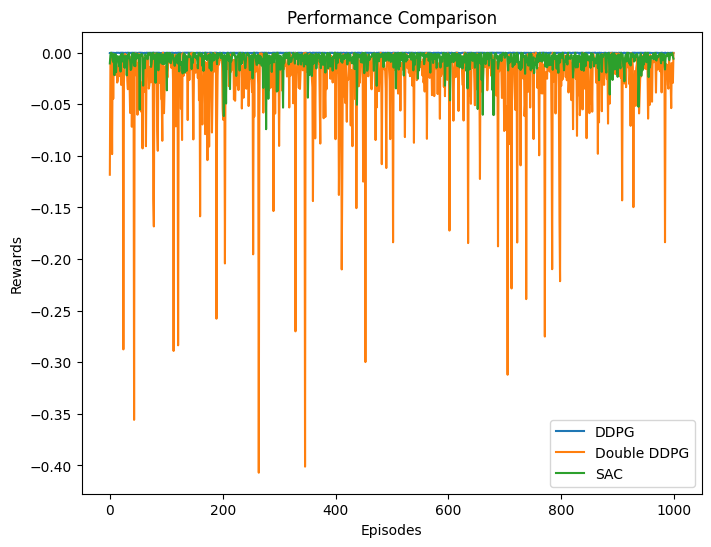

In [4]:
# Evaluate and compare performance
ddpg_rewards = []
double_ddpg_rewards = []
sac_rewards = []

# Unwrap the environment to access the original env for evaluation
unwrapped_env = env.envs[0]

# Evaluate DDPG model
obs, _ = unwrapped_env.reset()
for _ in range(1000):
    action, _states = ddpg_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = unwrapped_env.step(action)
    ddpg_rewards.append(reward)
    if terminated:
        obs, _ = unwrapped_env.reset()

# Evaluate Double DDPG model
obs, _ = unwrapped_env.reset()
for _ in range(1000):
    action, _states = double_ddpg_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = unwrapped_env.step(action)
    double_ddpg_rewards.append(reward)
    if terminated:
        obs, _ = unwrapped_env.reset()

# Evaluate SAC model
obs, _ = unwrapped_env.reset()
for _ in range(1000):
    action, _states = sac_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = unwrapped_env.step(action)
    sac_rewards.append(reward)
    if terminated:
        obs, _ = unwrapped_env.reset()

# Plot the performance comparison
plt.figure(figsize=(8, 6))
plt.plot(ddpg_rewards, label='DDPG')
plt.plot(double_ddpg_rewards, label='Double DDPG')
plt.plot(sac_rewards, label='SAC')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Performance Comparison')
plt.legend()
plt.show()


THE END OF OPTIMIZATION USING DRL ALGORITHMS